# Import Libraries

In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from pandas.plotting import scatter_matrix
import sys
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_predict, KFold
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, RobustScaler
import statsmodels.formula.api as smf


% matplotlib inline

print('Python version', sys.version)
print('Pandas version', pd.__version__)
print('Numpy version', np.__version__)

Python version 3.6.3 |Anaconda, Inc.| (default, Oct  6 2017, 12:04:38) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
Pandas version 0.20.3
Numpy version 1.14.0


# Setup

## Import Data

In [2]:
features = pd.read_pickle('../data/feature_data.pkl')
target = pd.read_pickle('../data/target_data.pkl')

Drop rows with any null values

In [3]:
def clean_nans(feat, tar):
    """
    Make sure there aren't any rows with nan values
    """
    nan_index = pd.isnull(feat).any(1).nonzero()[0]
    
    if len(nan_index):
        feat.dropna(axis=0, how='any', inplace=True)
        feat.reset_index(drop=True, inplace=True)
        
        tar.drop(target.index[nan_index], inplace=True)
        tar.reset_index(drop=True, inplace=True)
        
    return feat, tar

In [4]:
features, target = clean_nans(features, target)

## Define Evaluation Metrics

In [5]:
class Stats:
    
    def __init__(self, X, y, model):
        self.data = X
        self.target = y
        self.model = model
        ## degrees of freedom population dep. variable variance
        self._dft = X.shape[0] - 1   
        ## degrees of freedom population error variance
        self._dfe = X.shape[0] - X.shape[1] - 1  
        
    def sse(self):
        '''returns sum of squared errors (model vs actual)'''
        squared_errors = (self.target - self.model.predict(self.data)) ** 2
        return np.sum(squared_errors)

    def sst(self):
        '''returns total sum of squared errors (actual vs avg(actual))'''
        avg_y = np.mean(self.target)
        squared_errors = (self.target - avg_y) ** 2
        return np.sum(squared_errors)
    
    def r_squared(self):
        '''returns calculated value of r^2'''
        return 1 - self.sse()/self.sst()
    
    def adj_r_squared(self):
        '''returns calculated value of adjusted r^2'''
        return 1 - (self.sse()/self._dfe) / (self.sst()/self._dft)
    
    def rmse(self):
        '''returns the root mean squared error'''
        mse = mean_squared_error(self.target, self.model.predict(self.data))
        return np.sqrt(mse)



In [6]:
def calc_train_error(X_train, y_train, model):
    '''returns in-sample error for already fit model.'''

    stats = Stats(X_train, y_train, model)
    rmse = stats.rmse()
    adj_r_sqr = stats.adj_r_squared()
    
    return rmse, adj_r_sqr 
    
    
def calc_validation_error(X_test, y_test, model):
    '''returns out-of-sample error for already fit model.'''
    
    stats = Stats(X_test, y_test, model)
    rmse = stats.rmse()
    adj_r_sqr = stats.adj_r_squared()
    
    return rmse, adj_r_sqr 
    
    
def calc_metrics(X_train, y_train, X_test, y_test, model):
    '''fits model and returns the RMSE for in-sample error and out-of-sample error'''
    model.fit(X_train, y_train)

    train_rmse, train_adj_r = calc_train_error(X_train, y_train, model)
    validation_rmse, validation_adj_r = calc_validation_error(X_test, y_test, model)
            
    return train_rmse, train_adj_r, validation_rmse, validation_adj_r

In [7]:
def pretty_print_stats(train_rmse, train_adj_r, validation_rmse, validation_adj_r):
    '''returns report of statistics for a given model object'''
    
    adj_r = ( ('Training :', train_adj_r), ('Validation :', validation_adj_r) )
    rmse = ( ('Training :', train_rmse), ('Validation :', validation_rmse) )
    
    print('Adjusted R^2')
    for item in adj_r:
        print('{0:12} {1:.4f}'.format(item[0], item[1]))
      
    print('')
        
    print('RMSE')
    for item in rmse:
        print('{0:12} {1:.4f}'.format(item[0], item[1]))

## Define Cross Validation Function

In [31]:
def cross_validation_kfold(features, target, num_folds, model, scale=True):
    """
    Takes in feature set, target, model and number of folds to evaluate the in and out of sample error
    Returns the train and validation errors
    """
    K = num_folds
    kf = KFold(n_splits=K, shuffle=True, random_state=42)
    
    if len(np.shape(features))==1:
        features = pd.DataFrame(np.array(features).reshape(-1,1))

    # Initialize lists for capturing error terms at each fold of training and validation sets
    train_rmse_l = []
    train_adj_r_l = []
    validation_rmse_l = []
    validation_adj_r_l = []
    
    for train_index, val_index in kf.split(features, target):
        
        # split data
        X_train, X_val = features.loc[train_index], features.loc[val_index]
        y_train, y_val = target[train_index], target[val_index]
        
        if scale:
            # scale data
            scaler = RobustScaler()
            X_train = scaler.fit_transform(X_train)
            X_val = scaler.transform(X_val)

        # calculate errors
        train_rmse, train_adj_r, validation_rmse, validation_adj_r = calc_metrics(X_train = X_train, 
                                                                                  y_train = y_train, 
                                                                                  X_test = X_val, 
                                                                                  y_test = y_val, 
                                                                                  model = model)


        # append to appropriate list
        train_rmse_l.append(train_rmse)
        train_adj_r_l.append(train_adj_r)
        validation_rmse_l.append(validation_rmse)
        validation_adj_r_l.append(validation_adj_r)
        
        
    # generate report    
    pretty_print_stats(train_rmse=np.mean(train_rmse_l), 
                       train_adj_r=np.mean(train_adj_r_l), 
                       validation_rmse=np.mean(validation_rmse_l), 
                       validation_adj_r=np.mean(validation_adj_r_l))
              

## Define Plotting Functions

In [32]:
def plot_predictions(x, y, model_obj):
    """
    Takes in features, target and a model object and returns plot of cross val predictions
    """
    model_obj.fit(x, y)
    predicted = model_obj.predict(x)

    fig, ax = plt.subplots(figsize=(7, 4))
    ax.scatter(predicted, y, edgecolors=(0, 0, 0), alpha=.5, color='blue')
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
    
    ax.set_title('Actual Target by Predicted Target', size=20)
    ax.set_xlabel('Predicted Target', size=12)
    ax.set_ylabel('Actual Target', size=12)
    
    plt.show();

In [33]:
def plot_residuals(x, y, model_obj):
    
    model_obj.fit(x, y)
    
    predictions = model_obj.predict(x)
    residuals_linear = y - predictions
    
    fig, ax = plt.subplots(figsize=(7,4))
    plt.plot(predictions, residuals_linear, 'bo', alpha=.5, color='r')
    plt.axhline(y=0, color='k')
    plt.grid()
    
    ax.set_title('Residuals by Predicted Target', size=20)
    ax.set_xlabel('Predicted Target', size=12)
    ax.set_ylabel('Residuals', size=12)

    plt.show;

# Model Testing

## Review Correlations

Let's revisit our features to find the most correlated feature so we can start there

In [34]:
target_features = pd.concat([target, features], axis=1)

In [35]:
def fancy_corr(corr):
    cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)
    
    return corr.style.background_gradient(cmap, axis=1)\
            .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
            .set_precision(2)

In [36]:
fancy_corr(target_features.corr())


,Graduation_Rate_School,Average_ACT_School,crimes_per_student,dollars_per_student,percent_diff_budget,percent_low_income,is_selective_enroll,Average_ACT_log,crimes_student_log,dollars_student_log
Graduation_Rate_School,1,0.7,-0.51,-0.34,-0.0071,-0.45,0.41,0.74,-0.54,-0.39
Average_ACT_School,0.7,1,-0.44,-0.43,0.091,-0.83,0.7,0.99,-0.53,-0.48
crimes_per_student,-0.51,-0.44,1,0.56,0.0063,0.35,-0.21,-0.48,0.85,0.53
dollars_per_student,-0.34,-0.43,0.56,1,0.17,0.34,-0.28,-0.45,0.51,0.95
percent_diff_budget,-0.0071,0.091,0.0063,0.17,1,-0.11,-0.045,0.11,-0.12,0.2
percent_low_income,-0.45,-0.83,0.35,0.34,-0.11,1,-0.59,-0.81,0.49,0.36
is_selective_enroll,0.41,0.7,-0.21,-0.28,-0.045,-0.59,1,0.66,-0.25,-0.31
Average_ACT_log,0.74,0.99,-0.48,-0.45,0.11,-0.81,0.66,1,-0.56,-0.5
crimes_student_log,-0.54,-0.53,0.85,0.51,-0.12,0.49,-0.25,-0.56,1,0.49
dollars_student_log,-0.39,-0.48,0.53,0.95,0.2,0.36,-0.31,-0.5,0.49,1


Ok, so let's start with a simple univariate model on the **Average ACT log** feature

In [37]:
lr = LinearRegression(fit_intercept=True)

## Feature Selection Using Stats Models

In [173]:
stats_lr = smf.ols('Graduation_Rate_School ~ \
                   Average_ACT_log + percent_low_income + crimes_student_log + \
                   is_selective_enroll + dollars_per_student', \
                   data=target_features)

fit_stats_lr = stats_lr.fit()
fit_stats_lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     Graduation_Rate_School   R-squared:                       0.636
Model:                                OLS   Adj. R-squared:                  0.614
Method:                     Least Squares   F-statistic:                     29.30
Date:                    Thu, 01 Feb 2018   Prob (F-statistic):           4.28e-17
Time:                            17:30:54   Log-Likelihood:                -317.01
No. Observations:                      90   AIC:                             646.0
Df Residuals:                          84   BIC:                             661.0
Df Model:                               5                                         
Covariance Type:                nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            -193.2158     35.570     -5.432      0.000    -263.950    -122.482
Average_ACT_log        80.5489     10.426      7.725      0.000      59.815     101.283
percent_low_income     37.9869     10.067      3.774      0.000      17.968      58.005
crimes_student_log     -2.5109      0.971     -2.586      0.011      -4.442      -0.580
is_selective_enroll    -2.0426      3.769     -0.542      0.589      -9.538       5.453
dollars_per_student     0.0002      0.000      0.985      0.327      -0.000       0.001
==============================================================================
Omnibus:                        0.796   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.672   Jarque-Bera (JB):                0.611
Skew:                          -0.202   Prob(JB):                        0.737
Kurtosis:                       2.997   Cond. No.                     4.65e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.65e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Wow! I can see that the top three features above have p-values well below .05 - I'm going to go ahead and use these as my primary features for model testing below. 

First, I'll try running a polynomial transformation on the features below to see if any of the interaction terms are especially powerful

In [186]:
feature_transform = features.filter(['Average_ACT_log', 'percent_low_income', 'crimes_student_log'], axis=1)

poly = PolynomialFeatures(2)
feature_transform = pd.DataFrame(poly.fit_transform(feature_transform),
                                columns=['Average_ACT_log', 'percent_low_income', 'crimes_student_log', \
                                         'poly1', 'poly2', 'poly3', 'poly4', 'poly5', 'poly6', 'poly7'])

transformed_target_features = pd.concat([target, feature_transform], axis=1)

stats_lr = smf.ols('Graduation_Rate_School ~ \
                   Average_ACT_log + percent_low_income + crimes_student_log + \
                   poly1 + poly2 + poly3 + poly4 + poly5 + poly6 + poly7', \
                   data=transformed_target_features, )


fit_stats_lr = stats_lr.fit()
fit_stats_lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     Graduation_Rate_School   R-squared:                       0.682
Model:                                OLS   Adj. R-squared:                  0.646
Method:                     Least Squares   F-statistic:                     19.07
Date:                    Thu, 01 Feb 2018   Prob (F-statistic):           1.42e-16
Time:                            17:42:38   Log-Likelihood:                -310.86
No. Observations:                      90   AIC:                             641.7
Df Residuals:                          80   BIC:                             666.7
Df Model:                               9                                         
Covariance Type:                nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           -878.4055    423.264     -2.075      0.041   -1720.727     -36.084
Average_ACT_log     -878.4055    423.264     -2.075      0.041   -1720.727     -36.084
percent_low_income   948.7671    496.855      1.910      0.060     -40.005    1937.540
crimes_student_log   689.2954    417.257      1.652      0.102    -141.072    1519.663
poly1                -53.7962     37.535     -1.433      0.156    -128.493      20.901
poly2               -119.2911     74.410     -1.603      0.113    -267.372      28.789
poly3               -172.4962    108.824     -1.585      0.117    -389.063      44.070
poly4                 17.1869     10.679      1.609      0.111      -4.065      38.439
poly5                -91.2172     77.169     -1.182      0.241    -244.789      62.354
poly6                  7.9783     11.349      0.703      0.484     -14.606      30.563
poly7                  0.6066      0.547      1.110      0.270      -0.481       1.694
==============================================================================
Omnibus:                        0.917   Durbin-Watson:                   2.184
Prob(Omnibus):                  0.632   Jarque-Bera (JB):                0.582
Skew:                          -0.189   Prob(JB):                        0.747
Kurtosis:                       3.110   Cond. No.                     7.69e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.1e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

So, some of these are ok - I would junk the last three there and keep the others - but I can't see the interaction names here so I'm not sure how to interpret this..

For now, I'll just test the features one by one in a linear model

## Testing Linear Regression

In [189]:
def test_new_model(feature_set, target, model=lr, num_folds=7):
    """
    Takes in new feature set or model to evaluate in cross validation
    Returns error metrics report, residual plot and model prediction plot
    """
    cross_validation_kfold(features=feature_set,
                              target=target,
                              num_folds=num_folds,
                              model=model)
        
    plot_residuals(x=feature_set, y=target, model_obj=model)
    
    plot_predictions(x=feature_set, y=target, model_obj=model)
    

### Average ACT

Adjusted R^2
Training :   0.5384
Validation : 0.4675

RMSE
Training :   9.1540
Validation : 9.1778


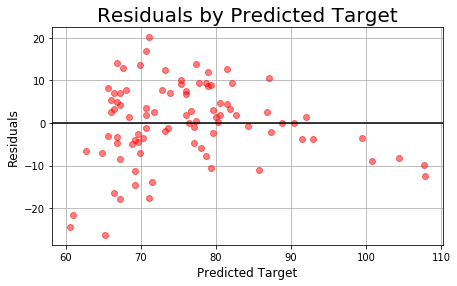

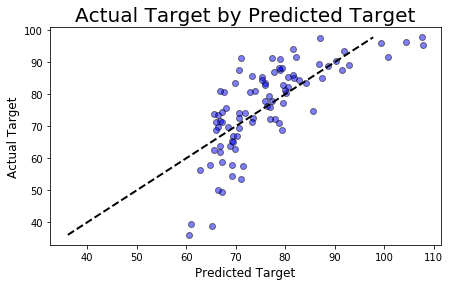

In [190]:
feature_set = features.filter(['Average_ACT_log'], axis=1)
test_new_model(feature_set, target)

This R squared isn't very good... but the in and out of sample error are pretty close together. If I have high error but my low variance between the two samples I can conclude that my model is **underfitting the data**

It looks like there is a non-linear relationship between my feature and target so I'll try to capture more of that with a log transformation and adding polynomial terms

First, let's see if we can improve this by **log transforming the target**

#### Log Transform Target

Adjusted R^2
Training :   0.4800
Validation : 0.4073

RMSE
Training :   0.0542
Validation : 0.0540


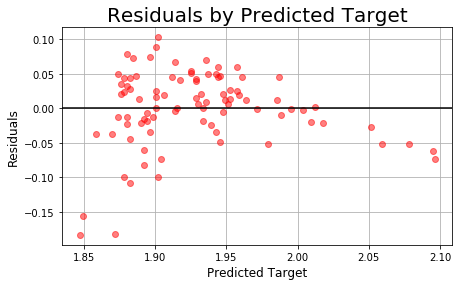

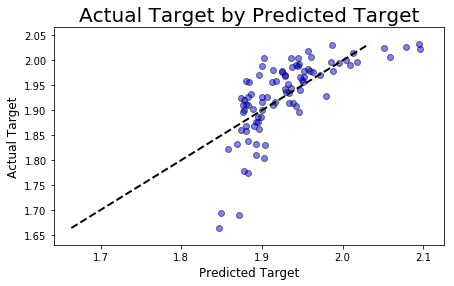

In [191]:
feature_set = features.filter(['Average_ACT_log'], axis=1)

y_log = np.log10(np.array(target) + 1e1)

test_new_model(feature_set, y_log)

Hmm, looking at the adjustedthat actually seems to have made things worse... let's try adding a **polynomial** term to capture more of the non-linear relationship between our feature and target

#### Add Polynomial Term

Adjusted R^2
Training :   0.6503
Validation : 0.5755

RMSE
Training :   7.9661
Validation : 8.1410


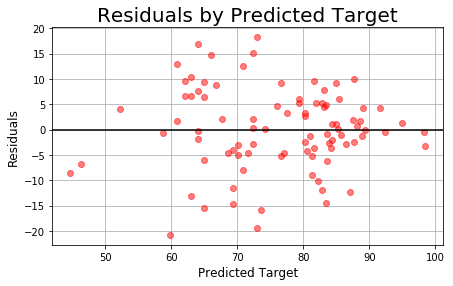

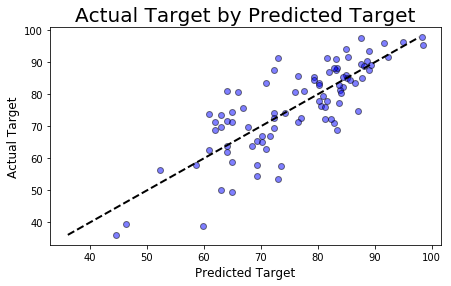

In [225]:
feature_set = features.filter(['Average_ACT_log'], axis=1)

poly = Pipeline([('poly', PolynomialFeatures(degree=3)),
                  ('linear', LinearRegression(fit_intercept=False))])

test_new_model(feature_set, target, poly)

Wow!!! This looks so much better! Since there isn't much variance between my in and out of sample error, I wonder if I can improve it by adding additional features. 

### Average ACT & Crime

Adjusted R^2
Training :   0.6536
Validation : 0.5059

RMSE
Training :   7.8769
Validation : 8.3915


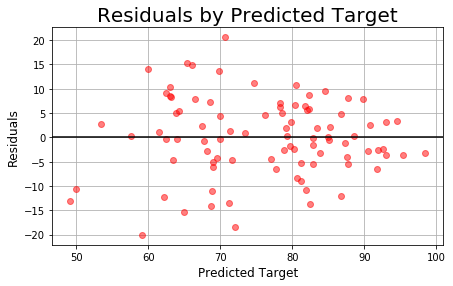

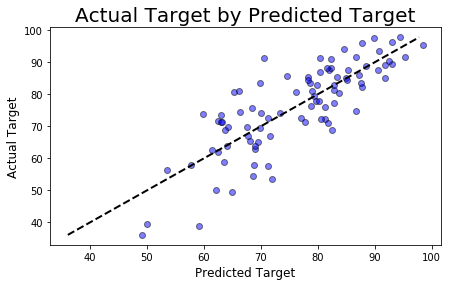

In [223]:
feature_set = features.filter(['Average_ACT_log', 'crimes_student_log'], axis=1)

poly = Pipeline([('poly', PolynomialFeatures(degree=2)),
                  ('linear', LinearRegression(fit_intercept=False))])

test_new_model(feature_set, target, poly)

Adding this term just slightly decreases my in sample error, but my validation error jumps up a lot... maybe a different term is needed? 

### Average ACT & Selective Enrollment

Adjusted R^2
Training :   0.6357
Validation : 0.4968

RMSE
Training :   8.0766
Validation : 8.4411


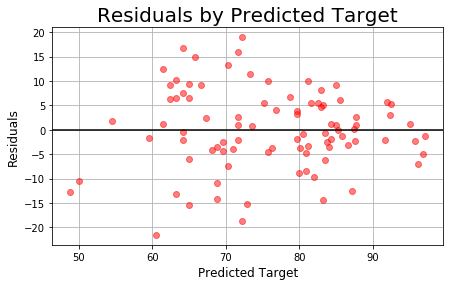

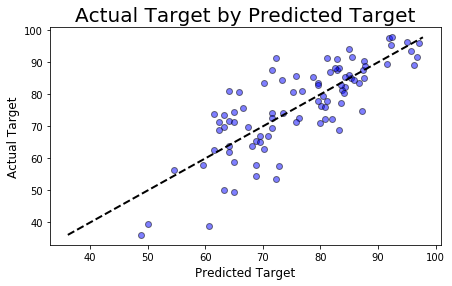

In [221]:
feature_set = features.filter(['Average_ACT_log', 'is_selective_enroll'], axis=1)

poly = Pipeline([('poly', PolynomialFeatures(degree=2)),
                  ('linear', LinearRegression(fit_intercept=False))])

test_new_model(feature_set, target, poly)

### Average ACT  & percent_low_income

Adjusted R^2
Training :   0.6575
Validation : 0.5302

RMSE
Training :   7.8323
Validation : 8.2364


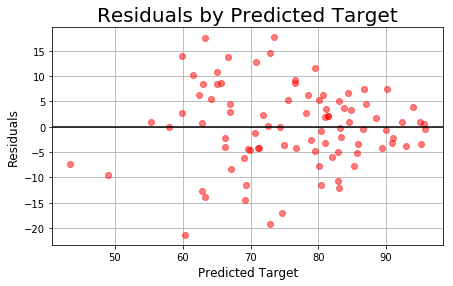

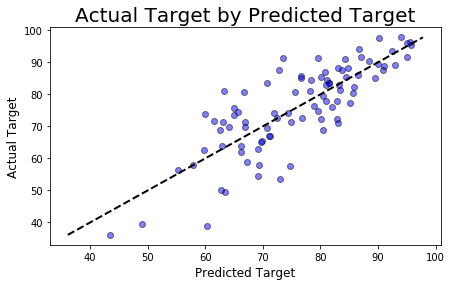

In [220]:
feature_set = features.filter(['Average_ACT_log', 'percent_low_income'], axis=1)

poly = Pipeline([('poly', PolynomialFeatures(degree=2)),
                  ('linear', LinearRegression(fit_intercept=False))])

test_new_model(feature_set, target, poly)

### Average ACT & dollars_student_log

Adjusted R^2
Training :   0.6389
Validation : 0.5196

RMSE
Training :   8.0414
Validation : 8.2257


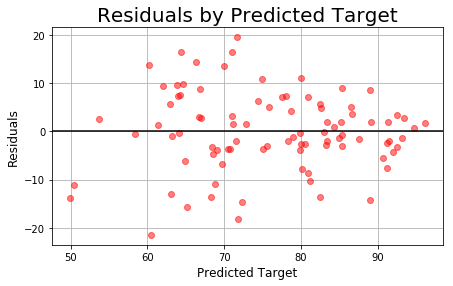

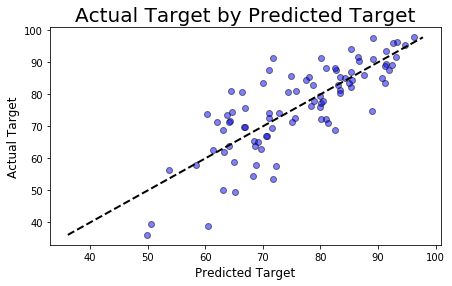

In [219]:
feature_set = features.filter(['Average_ACT_log', 'dollars_student_log'], axis=1)

poly = Pipeline([('poly', PolynomialFeatures(degree=2)),
                  ('linear', LinearRegression(fit_intercept=False))])

test_new_model(feature_set, target, poly)

### Average ACT & Crime & Percent Low Income

Adjusted R^2
Training :   0.6743
Validation : 0.4185

RMSE
Training :   7.5878
Validation : 8.6653


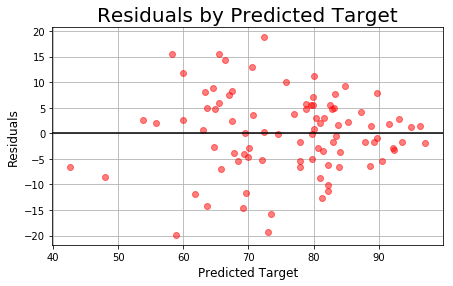

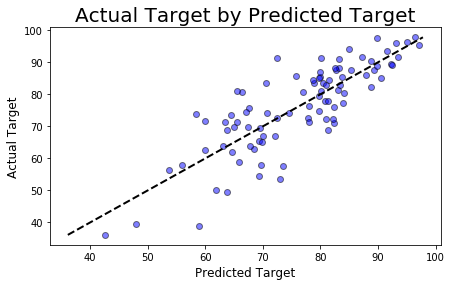

In [218]:
feature_set = features.filter(['Average_ACT_log', 'percent_low_income', 'crimes_student_log'], axis=1)
#target_log = np.log10(np.array(target))

poly = Pipeline([('poly', PolynomialFeatures(degree=2)),
                  ('linear', LinearRegression(fit_intercept=False))])

test_new_model(feature_set, target, poly)

This seems 

## Testing Lasso Regression (L1)

In [105]:
def lasso_test(data, target, num_folds, alphas, scale=True):
    
    K = num_folds
    kf = KFold(n_splits=K, shuffle=True, random_state=42)
    
    for alpha in alphas:
            # Initialize lists for capturing error terms at each fold of training and validation sets
        train_rmse_l = []
        train_adj_r_l = []
        validation_rmse_l = []
        validation_adj_r_l = []

        for train_index, val_index in kf.split(data, target):

            # split data
            X_train, X_val = data.loc[train_index], data.loc[val_index]
            y_train, y_val = target[train_index], target[val_index]
            
            if scale:
                # scale data
                scaler = RobustScaler()
                X_train = scaler.fit_transform(X_train)
                X_val = scaler.transform(X_val)

            # instantiate model
            lasso = Lasso(alpha=alpha, fit_intercept=True, random_state=77)

            #calculate errors
            train_rmse, train_adj_r, validation_rmse, validation_adj_r = calc_metrics(X_train = X_train, 
                                                                                      y_train = y_train, 
                                                                                      X_test = X_val, 
                                                                                      y_test = y_val, 
                                                                                      model = lasso)
            

            # append to appropriate list
            train_rmse_l.append(train_rmse)
            train_adj_r_l.append(train_adj_r)
            validation_rmse_l.append(validation_rmse)
            validation_adj_r_l.append(validation_adj_r)

        # generate report
        print('alpha: {:6} | Train RMSE: {:7} | Val RMSE: {:7} | Train AdjR2: {:7} | Val AdjR2: {:7} '.
              format(alpha,
                     round(np.mean(train_rmse_l),4),
                     round(np.mean(validation_rmse_l),4),
                     round(np.mean(train_adj_r_l),4),
                     round(np.mean(validation_adj_r_l),4),
                    ))

In [97]:
alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2]

In [98]:
feature_set = features.filter(['Average_ACT_log', 
                                 'crimes_student_log', 
                                 'percent_low_income'], axis=1)

lasso_test(data=feature_set, target=target, 
           num_folds=5, alphas=alphas, scale=True)

alpha: 0.0001 | Train RMSE:  8.2276 | Val RMSE:  8.4586 | Train AdjR2:  0.6148 | Val AdjR2:  0.4858 
alpha:  0.001 | Train RMSE:  8.2276 | Val RMSE:  8.4586 | Train AdjR2:  0.6148 | Val AdjR2:  0.4858 
alpha:   0.01 | Train RMSE:  8.2277 | Val RMSE:  8.4586 | Train AdjR2:  0.6148 | Val AdjR2:  0.4857 
alpha:    0.1 | Train RMSE:  8.2342 | Val RMSE:  8.4646 | Train AdjR2:  0.6142 | Val AdjR2:  0.4839 
alpha:      1 | Train RMSE:  8.8484 | Val RMSE:  9.0889 | Train AdjR2:  0.5546 | Val AdjR2:  0.3869 
alpha:   10.0 | Train RMSE: 13.4762 | Val RMSE: 13.4397 | Train AdjR2: -0.0325 | Val AdjR2: -0.2592 
alpha:  100.0 | Train RMSE:  13.554 | Val RMSE: 13.5014 | Train AdjR2: -0.0441 | Val AdjR2: -0.2692 


So the best I did here with the features that won out in my feature selection process is an alpha of .0001 - it seems like adding regularization strength doesn't improve my model. 

The RMSE is the same here as it was with these features in a Linear model but the adjusted R^2 is only the same for the training sample - the adjusted R^2 for the validation set is significantly smaller


Let's try this with Ridge Regression and see if it beats the linear model

## Testing Ridge Regression (L2)

In [103]:
def ridge_test(data, target, num_folds, alphas, scale=True):
    
    K = num_folds
    kf = KFold(n_splits=K, shuffle=True, random_state=42)
    
    for alpha in alphas:
            # Initialize lists for capturing error terms at each fold of training and validation sets
        train_rmse_l = []
        train_adj_r_l = []
        validation_rmse_l = []
        validation_adj_r_l = []

        for train_index, val_index in kf.split(data, target):

            # split data
            X_train, X_val = data.loc[train_index], data.loc[val_index]
            y_train, y_val = target[train_index], target[val_index]
            
            if scale:
                # scale data
                scaler = RobustScaler()
                X_train = scaler.fit_transform(X_train)
                X_val = scaler.transform(X_val)

            # instantiate model
            ridge = Ridge(alpha=alpha, fit_intercept=True, random_state=77)

            #calculate errors
            train_rmse, train_adj_r, validation_rmse, validation_adj_r = calc_metrics(X_train = X_train, 
                                                                                      y_train = y_train, 
                                                                                      X_test = X_val, 
                                                                                      y_test = y_val, 
                                                                                      model = ridge)
            

            # append to appropriate list
            train_rmse_l.append(train_rmse)
            train_adj_r_l.append(train_adj_r)
            validation_rmse_l.append(validation_rmse)
            validation_adj_r_l.append(validation_adj_r)

        # generate report
        print('alpha: {:6} | Train RMSE: {:7} | Val RMSE: {:7} | Train AdjR2: {:7} | Val AdjR2: {:7} '.
              format(alpha,
                     round(np.mean(train_rmse_l),4),
                     round(np.mean(validation_rmse_l),4),
                     round(np.mean(train_adj_r_l),4),
                     round(np.mean(validation_adj_r_l),4),
                    ))

In [104]:
feature_set = features.filter(['Average_ACT_log', 
                                 'crimes_student_log', 
                                 'percent_low_income'], axis=1)

ridge_test(data=feature_set, target=target, 
           num_folds=10, alphas=alphas, scale=True)

alpha: 0.0001 | Train RMSE:  8.2381 | Val RMSE:  8.4646 | Train AdjR2:  0.6166 | Val AdjR2:  0.2698 
alpha:  0.001 | Train RMSE:  8.2381 | Val RMSE:  8.4646 | Train AdjR2:  0.6166 | Val AdjR2:  0.2698 
alpha:   0.01 | Train RMSE:  8.2381 | Val RMSE:  8.4644 | Train AdjR2:  0.6166 | Val AdjR2:  0.2699 
alpha:    0.1 | Train RMSE:  8.2382 | Val RMSE:  8.4624 | Train AdjR2:  0.6166 | Val AdjR2:  0.2704 
alpha:      1 | Train RMSE:  8.2476 | Val RMSE:  8.4515 | Train AdjR2:  0.6157 | Val AdjR2:  0.2737 
alpha:   10.0 | Train RMSE:  8.6481 | Val RMSE:  8.7221 | Train AdjR2:  0.5776 | Val AdjR2:  0.2276 
alpha:  100.0 | Train RMSE: 10.6385 | Val RMSE: 10.6146 | Train AdjR2:  0.3608 | Val AdjR2: -0.1235 


Here we have virtually the same thing - with an alpha of .01 and smaller, the RMSE seems to level off pretty even with the first Linear Regression model we ran.